# Expert Density Analysis for Federated Mixture of Experts

This notebook analyzes the impact of expert density (number of local experts per client) on model performance in federated learning scenarios with Mixture of Experts (MoE) architectures.

## Objectives

1. **Data Collection**: Download metrics from WandB for different expert density configurations
2. **Performance Analysis**: Compare perplexity vs. token consumption across configurations
3. **Efficiency Evaluation**: Assess the trade-offs between expert density and training efficiency
4. **Configuration Impact**: Understand how overlapping factors and client counts affect performance

## Key Metrics

- **Expert Density**: Number of local experts per client
- **Overlapping Factor**: Factor determining expert sharing across clients
- **Final Perplexity**: Model performance at the end of training
- **Total Tokens**: Computational cost measure
- **Efficiency**: Ratio of final perplexity to total tokens consumed

## Analysis Workflow

1. Load and filter runs from WandB based on run UUID patterns
2. Extract configuration parameters for each run
3. Download server and client metrics data
4. Compute perplexity vs. token relationships
5. Aggregate results by configuration parameters
6. Generate visualizations and summary statistics

In [1]:
import logging
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from fedmoe_plots.data_analysis import get_perplexity_versus_tokens
from fedmoe_plots.plotting_utils import configure_logging_for_jupyter
from fedmoe_plots.wandb_utils import (
    ClientRunNotFoundError,
    download_photon_metrics,
    get_clientrun_property_from_config,
    get_experts_global_batch_size,
    get_n_local_experts,
    get_non_experts_global_batch_size,
    get_run_uuid_from_config,
    remove_runs_by_regex,
)

configure_logging_for_jupyter()

log = logging.getLogger("experts_density.ipynb")

EXCLUDE_INCOMPLETE_RUNS = True

In [2]:
run_uuid_1 = "4e_rho_bspol_scratch"
run_uuid_2 = "8e_rho_bspol_scratch"
api = wandb.Api(timeout=100)
runs = api.runs(
    path="camlsys/photon",
    filters={"display_name": {"$regex": f"(^{run_uuid_1})|(^{run_uuid_2})"}},
)

In [3]:
for run in runs:
    log.info("Run name: %s, ID: %s, State: %s", run.name, run.id, run.state)

experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_123433_server, ID: 4e_rho_bspol_scratch-20250729_123433, State: failed
experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_123433_client_0, ID: 4e_rho_bspol_scratch-20250729_123433_client_0, State: crashed
experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_123433_client_1, ID: 4e_rho_bspol_scratch-20250729_123433_client_1, State: crashed
experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_130559_server, ID: 4e_rho_bspol_scratch-20250729_130559, State: finished
experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_130559_client_1, ID: 4e_rho_bspol_scratch-20250729_130559_client_1, State: crashed
experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_130559_client_0, ID: 4e_rho_bspol_scratch-20250729_130559_client_0, State: crashed
experts_density.ipynb - INFO - Run name: 4e_rho_bspol_scratch-20250729_142719_server, ID: 4e_rho_b

In [4]:
unique_n_total_clients = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["fl"]["n_total_clients"],
    )
    for run in runs
}
unique_local_batch_size = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["global_train_batch_size"],
    )
    for run in runs
}
unique_overlapping_factor = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["fl"]["experts_overlapping_factor"],
    )
    for run in runs
}
unique_n_total_experts = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=lambda config: config["llm_config"]["model"]["ffn_config"][
            "ff_n_experts"
        ],
    )
    for run in runs
}
unique_n_local_experts = {
    get_clientrun_property_from_config(
        run,
        get_property_fn=get_n_local_experts,
    )
    for run in runs
}
log.info(
    "Unique n_total_clients: %s, unique_local_batch_size: %s, "
    "unique_overlapping_factor: %s, unique_n_total_experts: %s, "
    "unique_n_local_experts: %s",
    unique_n_total_clients,
    unique_local_batch_size,
    unique_overlapping_factor,
    unique_n_total_experts,
    unique_n_local_experts,
)

experts_density.ipynb - INFO - Unique n_total_clients: {2, 4}, unique_local_batch_size: {256, 512, 128}, unique_overlapping_factor: {1, 2, 4}, unique_n_total_experts: {8, 4}, unique_n_local_experts: {8, 2, 4}


In [5]:
# Data collection and processing for expert density analysis

from fedmoe_plots.data_analysis import ColumnNotFoundError

log.info("🔄 Starting data collection and processing...")
log.info("Found %s runs to process", len(runs))
unique_run_uuids = {
    str(
        get_clientrun_property_from_config(
            run,
            get_property_fn=operator.itemgetter("run_uuid"),
        ),
    )
    for run in runs
}
results_list = []

for i, unique_run_uuid in enumerate(unique_run_uuids):
    log.info(
        "📊 Processing run %s/%s: %s",
        i + 1,
        len(unique_run_uuids),
        unique_run_uuid,
    )

    run: wandb.apis.public.Run | None = (  # pyright: ignore[reportAttributeAccessIssue]
        None
    )
    try:
        # Get any run that matches the unique run UUID
        run = next(r for r in runs if get_run_uuid_from_config(r) == unique_run_uuid)
        assert run is not None, f"Run with UUID {unique_run_uuid} not found"

        # Extract configuration parameters
        config = run.config
        run_uuid = get_clientrun_property_from_config(
            run,
            get_property_fn=operator.itemgetter("run_uuid"),
        )

        n_total_clients = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["fl"]["n_total_clients"],
        )

        n_total_experts = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"]["model"]["ffn_config"][
                "ff_n_experts"
            ],
        )

        overlapping_factor = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["fl"]["experts_overlapping_factor"],
        )

        global_train_batch_size = get_clientrun_property_from_config(
            run,
            get_property_fn=lambda config: config["llm_config"][
                "global_train_batch_size"
            ],
        )

        # Calculate derived metrics
        n_local_experts = get_n_local_experts(config)
        experts_global_batch_size = get_experts_global_batch_size(config)
        non_experts_global_batch_size = get_non_experts_global_batch_size(config)

        log.info(
            "📋 Configuration: TE=%s, LE=%s, Clients=%s, OF=%s",
            n_total_experts,
            n_local_experts,
            n_total_clients,
            overlapping_factor,
        )

        # Download and process data
        log.info("🔽 Downloading data for %s...", run_uuid)

        try:
            # Download photon metrics for the run
            assert run_uuid is not None, "Run UUID must not be None"
            assert isinstance(
                run_uuid,
                str,
            ), f"Run UUID must be a string not a {type(run_uuid)}"
            _s_df, clients_df = download_photon_metrics(
                base_name="camlsys/photon",
                run_uuid=run_uuid,
            )

            # Try to get perplexity vs tokens data
            assert n_total_clients is not None, "Total clients must not be None"
            assert isinstance(
                n_total_clients,
                int,
            ), f"Total clients must be an integer not a {type(n_total_clients)}"
            result = get_perplexity_versus_tokens(
                client_metrics_df=clients_df,
                n_clients_per_round=n_total_clients,
            )

            tokens, perplexity = result

            if len(tokens) == 0 or len(perplexity) == 0:
                log.warning("❌ Empty data arrays for %s", run_uuid)
                continue

            # Calculate metrics
            final_perplexity = (
                perplexity.iloc[-1] if len(perplexity) > 0 else float("nan")
            )
            total_tokens = tokens.iloc[-1] if len(tokens) > 0 else 0
            n_data_points = len(tokens)

            log.info(
                (
                    "   ✅ Data processed: %d points,"
                    " Final perplexity: %.4f, Total tokens: %.0f"
                ),
                n_data_points,
                final_perplexity,
                total_tokens,
            )

            # Store results
            results_list.append(
                {
                    "run_uuid": str(run_uuid),
                    "n_total_clients": n_total_clients,
                    "n_total_experts": n_total_experts,
                    "n_local_experts": n_local_experts,
                    "overlapping_factor": overlapping_factor,
                    "global_train_batch_size": global_train_batch_size,
                    "experts_global_batch_size": experts_global_batch_size,
                    "non_experts_global_batch_size": non_experts_global_batch_size,
                    "final_perplexity": final_perplexity,
                    "total_tokens": total_tokens,
                    "n_data_points": n_data_points,
                    "tokens": (
                        tokens.tolist() if hasattr(tokens, "tolist") else list(tokens)
                    ),
                    "perplexity": (
                        perplexity.tolist()
                        if hasattr(perplexity, "tolist")
                        else list(perplexity)
                    ),
                },
            )

        except ClientRunNotFoundError:
            # Log exception with stack trace
            log.exception(
                "   ⚠️  Client run not found for %s",
                run_uuid,
                stack_info=True,
            )

            # Remove this run from WandB runs to avoid further processing
            remove_runs_by_regex("camlsys/photon", f"^{run_uuid}*")
            continue

        except ColumnNotFoundError:
            log.exception(
                "   ⚠️ Column not found in client metrics DataFrame for %s. "
                "We assume this run crashed and doesn't have the expected data.",
                run_uuid,
                stack_info=True,
            )

            # Remove this run from WandB runs to avoid further processing
            remove_runs_by_regex("camlsys/photon", f"^{run_uuid}*")
            continue

        except Exception:
            log.exception("   ❌ Error processing %s", run_uuid, stack_info=True)
            continue

    except Exception:
        assert run is not None, "Run must not be None"
        log.exception(
            "   ❌ Error extracting config for run %s",
            run.name,
            stack_info=True,
        )
        continue

log.info("\n✅ Data collection completed!")
log.info("Successfully processed %d out of %d runs", len(results_list), len(runs))

experts_density.ipynb - INFO - 🔄 Starting data collection and processing...
experts_density.ipynb - INFO - Found 70 runs to process
experts_density.ipynb - INFO - 📊 Processing run 1/18: 4e_rho_bspol_scratch-20250729_174921
experts_density.ipynb - INFO - 📋 Configuration: TE=8, LE=2, Clients=4, OF=1
experts_density.ipynb - INFO - 🔽 Downloading data for 4e_rho_bspol_scratch-20250729_174921...
experts_density.ipynb - INFO -    ✅ Data processed: 224 points, Final perplexity: 110.4810, Total tokens: 233832448
experts_density.ipynb - INFO - 📊 Processing run 2/18: 4e_rho_bspol_scratch-20250730_011254
experts_density.ipynb - INFO - 📋 Configuration: TE=8, LE=4, Clients=4, OF=2
experts_density.ipynb - INFO - 🔽 Downloading data for 4e_rho_bspol_scratch-20250730_011254...
experts_density.ipynb - INFO -    ✅ Data processed: 416 points, Final perplexity: 36.8525, Total tokens: 435159040
experts_density.ipynb - INFO - 📊 Processing run 3/18: 4e_rho_bspol_scratch-20250730_060411
experts_density.ipynb - 

In [6]:
log.info("\n=== Summary ===")
log.info(
    "Successfully processed %d out of %d runs",
    len(results_list),
    len(unique_run_uuids),
)

# Check for runs that didn't reach 1 billion tokens and log warnings
incomplete_runs = []
complete_runs = []
if results_list:
    log.info("\n⚠️  TOKEN COUNT ANALYSIS ⚠️")
    log.info("=" * 60)

    billion_tokens = 1e9

    for result in results_list:
        if result["total_tokens"] < billion_tokens:
            incomplete_runs.append(result)
        else:
            complete_runs.append(result)

    if incomplete_runs:
        log.warning(
            "🔴 WARNING: %d run(s) did NOT reach 1 billion tokens:",
            len(incomplete_runs),
        )
        log.info("-" * 60)

        for i, result in enumerate(incomplete_runs, 1):
            log.info("\n%s. Run UUID: %s", i, result["run_uuid"])
            log.info(
                "   Total Tokens: %s (%.3fB)",
                format(result["total_tokens"], ","),
                result["total_tokens"] / 1e9,
            )
            log.info(
                "   Completion: %.1f%% of 1B tokens",
                result["total_tokens"] / billion_tokens * 100,
            )
            log.info("   📋 Full Configuration:")
            log.info("      • Total Experts: %s", result["n_total_experts"])
            log.info("      • Local Experts: %s", result["n_local_experts"])
            log.info("      • Total Clients: %s", result["n_total_clients"])
            log.info("      • Overlapping Factor: %.1f", result["overlapping_factor"])
            log.info(
                "      • Expert Global Batch Size: %s",
                result["experts_global_batch_size"],
            )
            log.info(
                "      • Non-Expert Global Batch Size: %s",
                result["non_experts_global_batch_size"],
            )
            log.info("      • Local Batch Size: %s", result["global_train_batch_size"])
            log.info("      • Final Perplexity: %.4f", result["final_perplexity"])
            log.info("      • Data Points: %s", result["n_data_points"])

    if complete_runs:
        log.info(
            "✅ %d run(s) successfully reached 1+ billion tokens:",
            len(complete_runs),
        )
        for result in complete_runs:
            log.info(
                "   • %s: %d tokens (%.3fB)",
                result["run_uuid"],
                result["total_tokens"],
                result["total_tokens"] / 1e9,
            )

    log.info("\n📊 Token Count Summary:")
    log.info("   • Complete runs (≥1B tokens): %d", len(complete_runs))
    log.info("   • Incomplete runs (<1B tokens): %d", len(incomplete_runs))
    if results_list:
        avg_tokens = sum(r["total_tokens"] for r in results_list) / len(results_list)
        log.info(
            "   • Average tokens across all runs: %.0f (%.3fB)",
            avg_tokens,
            avg_tokens / 1e9,
        )

# Convert to DataFrame for easier analysis
this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs
if this_cell_results_list:
    results_df = pd.DataFrame(this_cell_results_list)
    log.info("\nResults DataFrame shape: %s", results_df.shape)
    log.info("\nConfiguration summary:")
    summary_cols = [
        "run_uuid",
        "n_local_experts",
        "experts_global_batch_size",
        "non_experts_global_batch_size",
        "overlapping_factor",
        "final_perplexity",
        "n_total_experts",
    ]
    log.info(results_df[summary_cols].to_string(index=False, float_format="%.4f"))
else:
    log.info("No results to analyze")
    results_df = pd.DataFrame()

experts_density.ipynb - INFO - 
=== Summary ===
experts_density.ipynb - INFO - Successfully processed 18 out of 18 runs
experts_density.ipynb - INFO - 
⚠️  TOKEN COUNT ANALYSIS ⚠️
experts_density.ipynb - INFO - ============================================================
experts_density.ipynb - WARNING - 🔴 WARNING: 8 run(s) did NOT reach 1 billion tokens:
experts_density.ipynb - INFO - ------------------------------------------------------------
experts_density.ipynb - INFO - 
1. Run UUID: 4e_rho_bspol_scratch-20250729_174921
experts_density.ipynb - INFO -    Total Tokens: 233,832,448.0 (0.234B)
experts_density.ipynb - INFO -    Completion: 23.4% of 1B tokens
experts_density.ipynb - INFO -    📋 Full Configuration:
experts_density.ipynb - INFO -       • Total Experts: 8
experts_density.ipynb - INFO -       • Local Experts: 2
experts_density.ipynb - INFO -       • Total Clients: 4
experts_density.ipynb - INFO -       • Overlapping Factor: 1.0
experts_density.ipynb - INFO -       • Expert

experts_density.ipynb - INFO - Generating enhanced Expert Density Analysis with improved cosmetics...


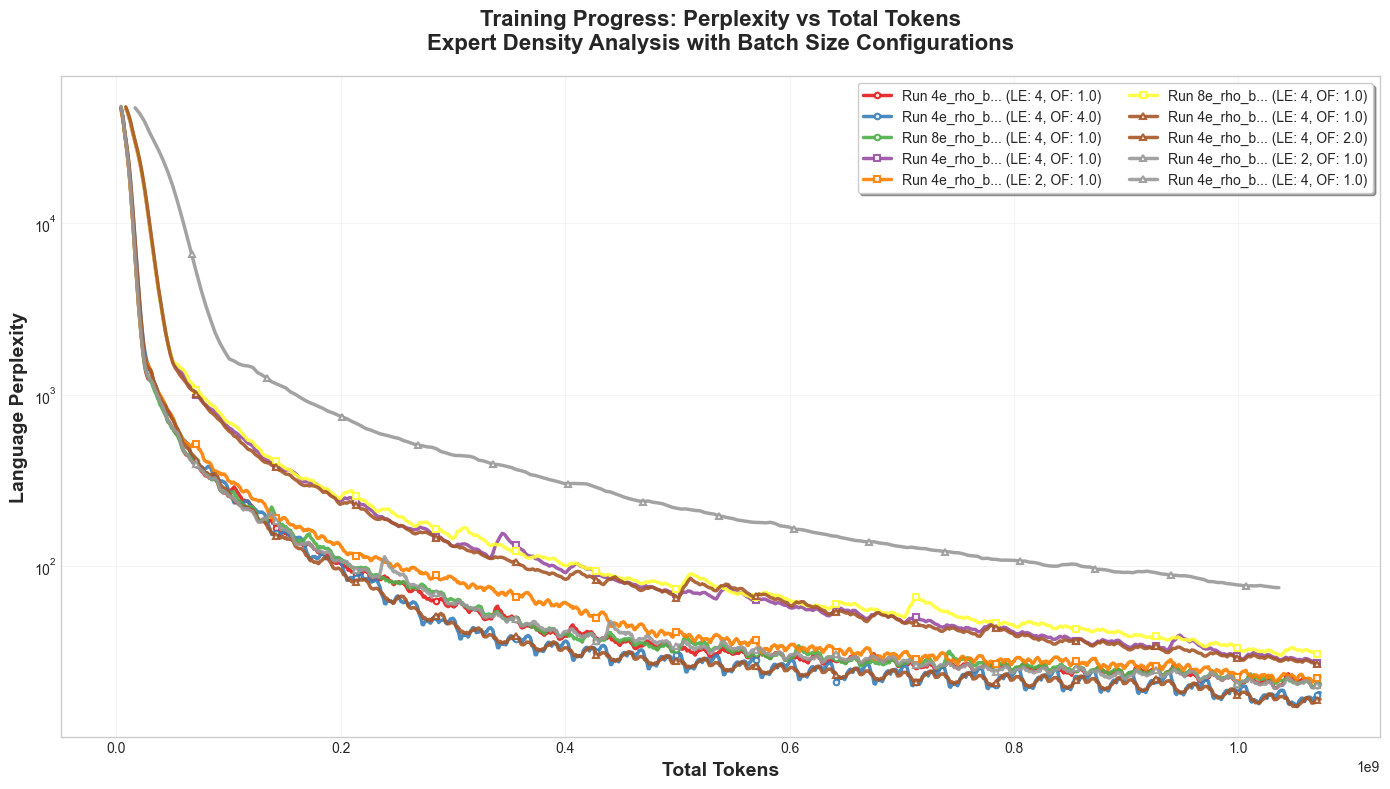

In [7]:
# Enhanced Expert Density Analysis with Independent, High-Quality Plots
log.info("Generating enhanced Expert Density Analysis with improved cosmetics...")

this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

if len(this_cell_results_list) > 0:
    # Quick token count check before plotting
    billion_tokens = 1e9
    incomplete_runs = [
        r for r in this_cell_results_list if r["total_tokens"] < billion_tokens
    ]

    if incomplete_runs:
        log.warning(
            "\n⚠️  ATTENTION: %s of %s runs didn't reach 1B tokens!",
            len(incomplete_runs),
            len(this_cell_results_list),
        )
        log.info("   This may affect training convergence analysis.\n")

    # Set up enhanced plotting style
    plt.style.use("seaborn-v0_8-whitegrid")
    colors = plt.cm.Set1(np.linspace(0, 1, len(this_cell_results_list)))

    # ==== PLOT 1: Training Progress - Perplexity vs Total Tokens ====
    plt.figure(figsize=(14, 8))

    for i, result in enumerate(this_cell_results_list):
        tokens = np.array(result["tokens"])
        perplexity = np.array(result["perplexity"])

        # Enhanced legend label with key information
        incomplete_indicator = " ⚠️" if result["total_tokens"] < billion_tokens else ""
        legend_label = (
            f"Run {result['run_uuid'][:8]}...{incomplete_indicator} "
            f"(LE: {result['n_local_experts']}, "
            f"OF: {result['overlapping_factor']:.1f})"
        )

        # Use different line style for incomplete runs
        linestyle = "--" if result["total_tokens"] < billion_tokens else "-"
        alpha = 0.7 if result["total_tokens"] < billion_tokens else 0.9
        linewidth = 2.0 if result["total_tokens"] < billion_tokens else 2.5

        plt.plot(
            tokens,
            perplexity,
            label=legend_label,
            linewidth=linewidth,
            alpha=alpha,
            color=colors[i],
            linestyle=linestyle,
            marker="o" if i < 3 else ("s" if i < 6 else "^"),
            markersize=4,
            markevery=max(1, len(tokens) // 15),
            markerfacecolor="white",
            markeredgewidth=1.5,
            markeredgecolor=colors[i],
        )

    plt.xlabel("Total Tokens", fontsize=14, fontweight="bold")
    plt.ylabel("Language Perplexity", fontsize=14, fontweight="bold")
    plt.title(
        "Training Progress: Perplexity vs Total Tokens\n"
        + "Expert Density Analysis with Batch Size Configurations",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )
    plt.yscale("log")
    plt.legend(
        frameon=True,
        fancybox=True,
        shadow=True,
        ncol=1 if len(this_cell_results_list) <= 4 else 2,
        fontsize=10,
        loc="upper right",
    )
    plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    plt.tight_layout()
    plt.show()

experts_density.ipynb - INFO - Generating enhanced Expert Density Analysis with improved cosmetics...


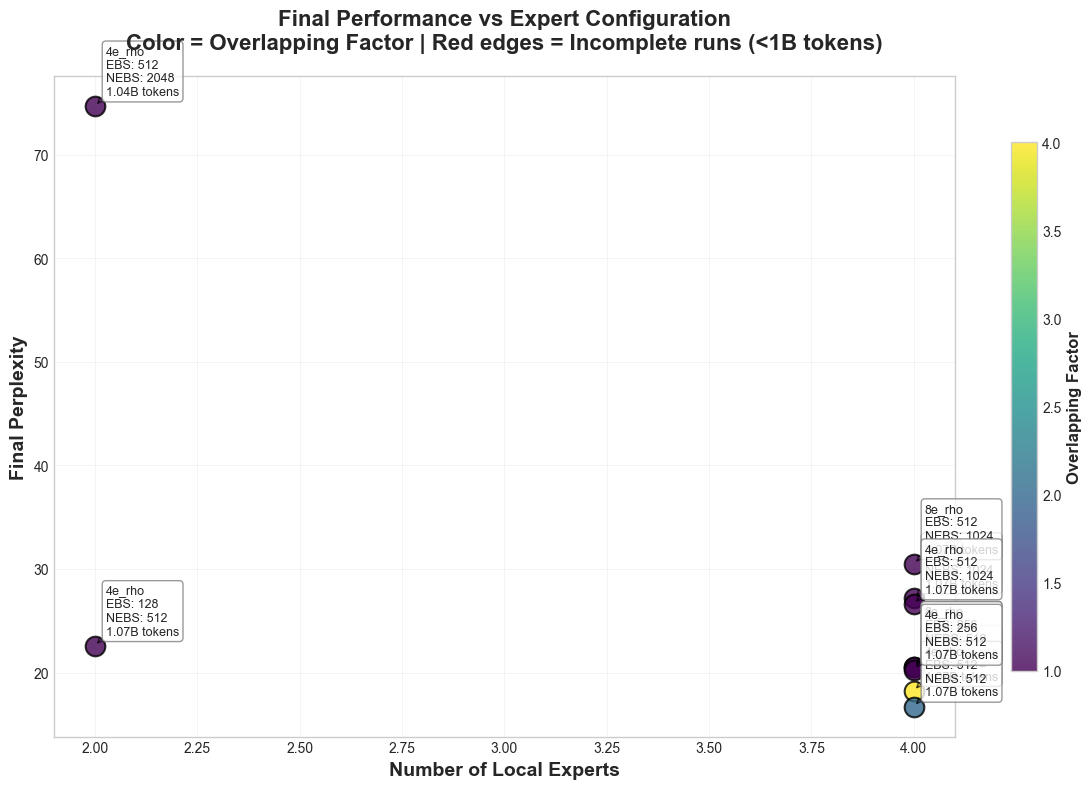

In [8]:
# Enhanced Expert Density Analysis with Independent, High-Quality Plots
log.info("Generating enhanced Expert Density Analysis with improved cosmetics...")

this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

if len(this_cell_results_list) > 0:
    # Quick token count check before plotting
    billion_tokens = 1e9
    incomplete_runs = [
        r for r in this_cell_results_list if r["total_tokens"] < billion_tokens
    ]

    if incomplete_runs:
        log.warning(
            "\n⚠️  ATTENTION: %s of %s runs didn't reach 1B tokens!",
            len(incomplete_runs),
            len(this_cell_results_list),
        )
        log.info("   This may affect training convergence analysis.\n")

    # Set up enhanced plotting style
    plt.style.use("seaborn-v0_8-whitegrid")
    colors = plt.cm.Set1(np.linspace(0, 1, len(this_cell_results_list)))
    # ==== PLOT 2: Final Performance Scatter ====
    plt.figure(figsize=(12, 8))

    # Create scatter plot with enhanced styling
    for i, result in enumerate(this_cell_results_list):
        marker = "o" if result["total_tokens"] >= billion_tokens else "^"
        alpha = 0.8 if result["total_tokens"] >= billion_tokens else 0.6
        edge_color = "darkred" if result["total_tokens"] < billion_tokens else "black"
        edge_width = 2.5 if result["total_tokens"] < billion_tokens else 1.5

        scatter = plt.scatter(
            result["n_local_experts"],
            result["final_perplexity"],
            c=result["overlapping_factor"],
            s=200,
            alpha=alpha,
            cmap="viridis",
            edgecolors=edge_color,
            linewidth=edge_width,
            marker=marker,
            vmin=min(r["overlapping_factor"] for r in this_cell_results_list),
            vmax=max(r["overlapping_factor"] for r in this_cell_results_list),
        )

    # Enhanced annotations
    for result in this_cell_results_list:
        incomplete_indicator = "⚠️" if result["total_tokens"] < billion_tokens else ""
        annotation_text = (
            f"{result['run_uuid'][:6]}{incomplete_indicator}\n"
            f"EBS: {result['experts_global_batch_size']}\n"
            f"NEBS: {result['non_experts_global_batch_size']}\n"
            f"{result['total_tokens'] / 1e9:.2f}B tokens"
        )
        plt.annotate(
            annotation_text,
            (result["n_local_experts"], result["final_perplexity"]),
            xytext=(8, 8),
            textcoords="offset points",
            fontsize=9,
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="gray"
            ),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1", alpha=0.6),
        )

    plt.xlabel("Number of Local Experts", fontsize=14, fontweight="bold")
    plt.ylabel("Final Perplexity", fontsize=14, fontweight="bold")
    plt.title(
        "Final Performance vs Expert Configuration\n"
        + "Color = Overlapping Factor | Red edges = Incomplete runs (<1B tokens)",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )

    cbar = plt.colorbar(scatter, shrink=0.8, aspect=20)
    cbar.set_label("Overlapping Factor", fontsize=12, fontweight="bold")
    cbar.ax.tick_params(labelsize=10)

    plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    plt.tight_layout()
    plt.show()

experts_density.ipynb - INFO - Generating enhanced Expert Density Analysis with improved cosmetics...


/tmp/ipykernel_3766277/3217889769.py:73: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_3766277/3217889769.py:73: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_3766277/3217889769.py:73: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/nfs-share/ls985/projects/fedmoe_plots/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/nfs-share/ls985/projects/fedmoe_plots/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/nfs-share/ls985/projects/fedmoe_plots/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SE

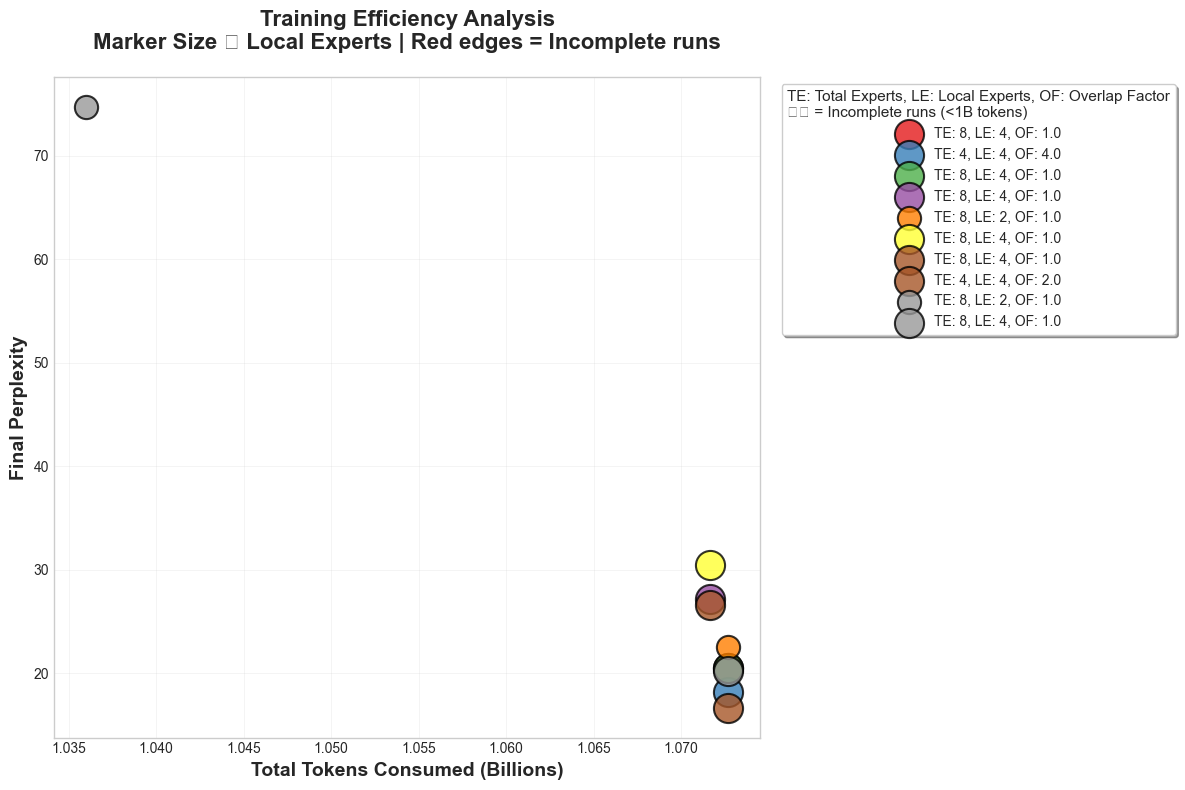

/tmp/ipykernel_3766277/3217889769.py:137: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_3766277/3217889769.py:137: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()


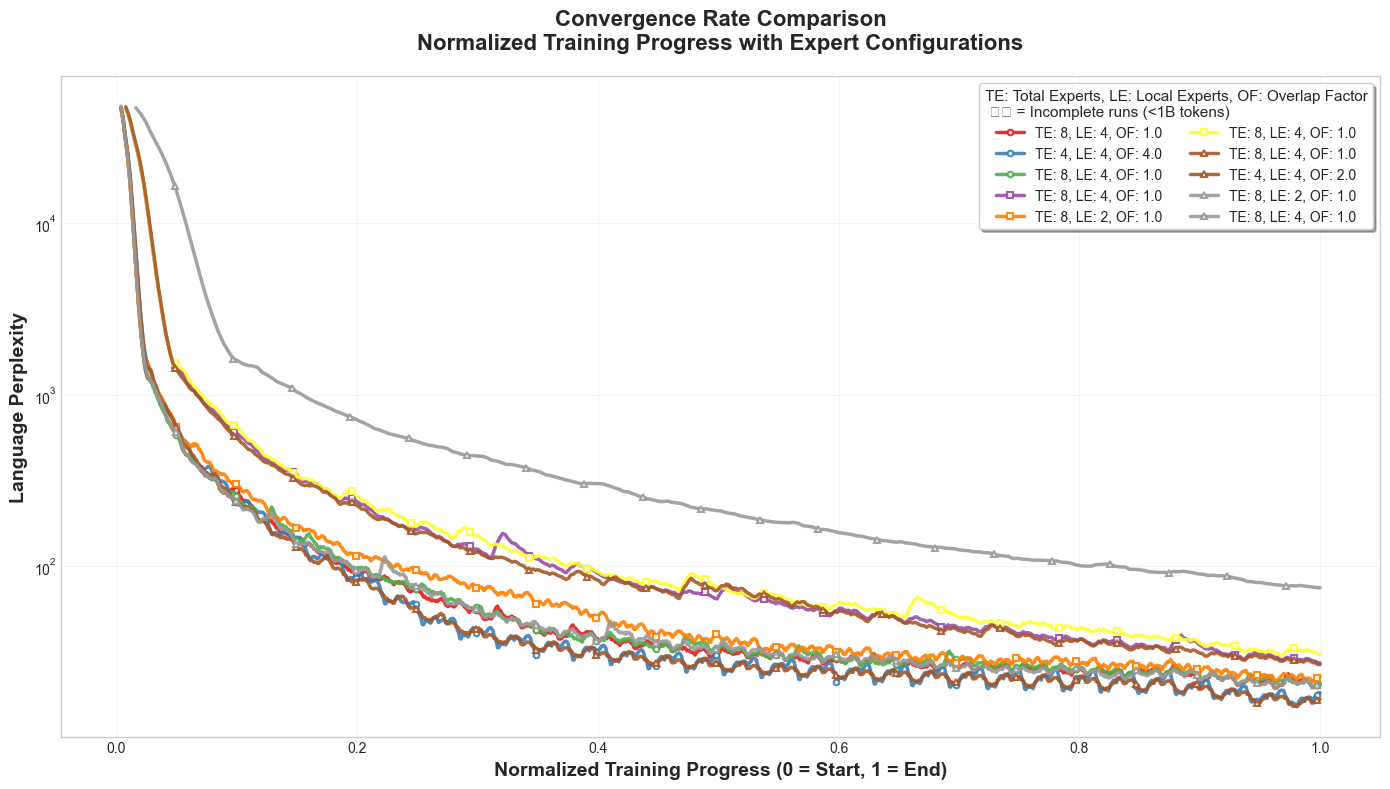

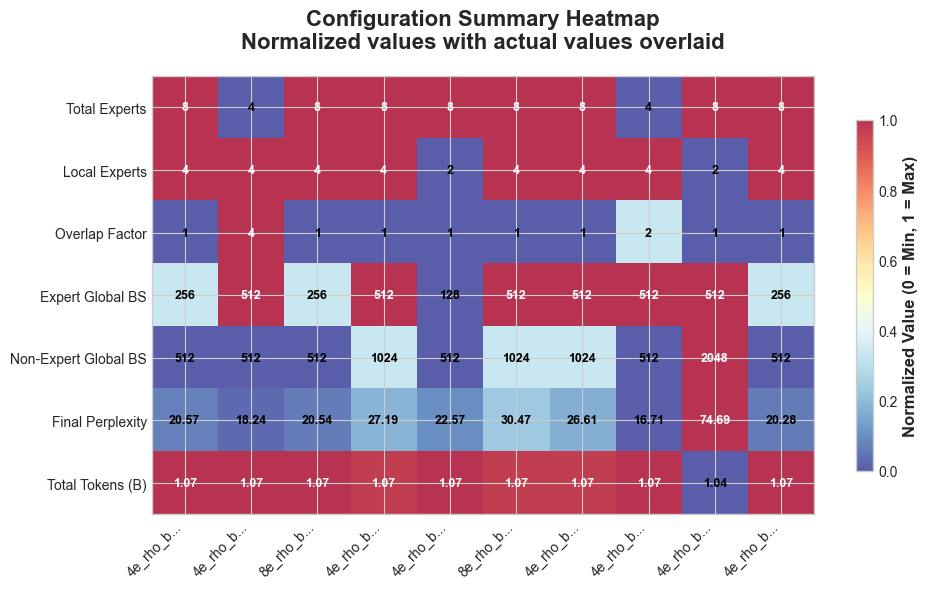

experts_density.ipynb - INFO - ✅ Enhanced analysis with improved cosmetics completed!
experts_density.ipynb - INFO - 📊 Generated 5 independent plots:
experts_density.ipynb - INFO -    1. Training Progress (Perplexity vs Tokens)
experts_density.ipynb - INFO -    2. Final Performance Scatter
experts_density.ipynb - INFO -    3. Training Efficiency Analysis
experts_density.ipynb - INFO -    4. Convergence Rate Comparison
experts_density.ipynb - INFO -    5. Configuration Summary Heatmap


In [9]:
# Enhanced Expert Density Analysis with Independent, High-Quality Plots
log.info("Generating enhanced Expert Density Analysis with improved cosmetics...")

this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

if len(this_cell_results_list) > 0:
    # Quick token count check before plotting
    billion_tokens = 1e9
    incomplete_runs = [
        r for r in this_cell_results_list if r["total_tokens"] < billion_tokens
    ]

    if incomplete_runs:
        log.warning(
            "\n⚠️  ATTENTION: %s of %s runs didn't reach 1B tokens!",
            len(incomplete_runs),
            len(this_cell_results_list),
        )
        log.info("   This may affect training convergence analysis.\n")

    # Set up enhanced plotting style
    plt.style.use("seaborn-v0_8-whitegrid")
    colors = plt.cm.Set1(np.linspace(0, 1, len(this_cell_results_list)))
    # ==== PLOT 3: Training Efficiency Analysis ====
    plt.figure(figsize=(12, 8))

    for i, result in enumerate(this_cell_results_list):
        incomplete_indicator = " ⚠️" if result["total_tokens"] < billion_tokens else ""
        alpha = 0.7 if result["total_tokens"] < billion_tokens else 0.8
        edge_color = "darkred" if result["total_tokens"] < billion_tokens else "black"
        edge_width = 2.5 if result["total_tokens"] < billion_tokens else 1.5

        plt.scatter(
            result["total_tokens"] / 1e9,  # Convert to billions for readability
            result["final_perplexity"],
            s=result["n_local_experts"] * 80
            + 120,  # Size proportional to local experts
            alpha=alpha,
            color=colors[i],
            edgecolors=edge_color,
            linewidth=edge_width,
            label=(
                f"TE: {result['n_total_experts']}, "
                f"LE: {result['n_local_experts']}, "
                f"OF: {result['overlapping_factor']:.1f}"
                f"{incomplete_indicator}"
            ),
        )

    plt.xlabel("Total Tokens Consumed (Billions)", fontsize=14, fontweight="bold")
    plt.ylabel("Final Perplexity", fontsize=14, fontweight="bold")
    plt.title(
        "Training Efficiency Analysis\n"
        + "Marker Size ∝ Local Experts | Red edges = Incomplete runs",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )

    plt.legend(
        title="TE: Total Experts, LE: Local Experts, OF: Overlap Factor\n⚠️ = Incomplete runs (<1B tokens)",
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=10,
        title_fontsize=11,
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
    )
    plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # ==== PLOT 4: Convergence Rate Comparison ====
    plt.figure(figsize=(14, 8))

    for i, result in enumerate(this_cell_results_list):
        tokens = np.array(result["tokens"])
        perplexity = np.array(result["perplexity"])

        if len(tokens) > 1:
            tokens_norm = (tokens - tokens.min()) / (tokens.max() - tokens.min())
            incomplete_indicator = (
                " ⚠️" if result["total_tokens"] < billion_tokens else ""
            )
            linestyle = "--" if result["total_tokens"] < billion_tokens else "-"
            alpha = 0.7 if result["total_tokens"] < billion_tokens else 0.9
            linewidth = 2.0 if result["total_tokens"] < billion_tokens else 2.5

            plt.plot(
                tokens_norm,
                perplexity,
                label=(
                    f"TE: {result['n_total_experts']}, "
                    f"LE: {result['n_local_experts']}, "
                    f"OF: {result['overlapping_factor']:.1f}"
                    f"{incomplete_indicator}"
                ),
                linewidth=linewidth,
                alpha=alpha,
                linestyle=linestyle,
                color=colors[i],
                marker="o" if i < 3 else ("s" if i < 6 else "^"),
                markersize=4,
                markevery=max(1, len(tokens_norm) // 20),
                markerfacecolor="white",
                markeredgewidth=1.5,
                markeredgecolor=colors[i],
            )

    plt.xlabel(
        "Normalized Training Progress (0 = Start, 1 = End)",
        fontsize=14,
        fontweight="bold",
    )
    plt.ylabel("Language Perplexity", fontsize=14, fontweight="bold")
    plt.title(
        "Convergence Rate Comparison\n"
        + "Normalized Training Progress with Expert Configurations",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )
    plt.yscale("log")
    plt.legend(
        title="TE: Total Experts, LE: Local Experts, OF: Overlap Factor\n ⚠️ = Incomplete runs (<1B tokens)",
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=10,
        title_fontsize=11,
        ncol=1 if len(this_cell_results_list) <= 4 else 2,
    )
    plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # ==== PLOT 5: Configuration Summary Heatmap ====
    plt.figure(figsize=(10, 6))

    # Create a summary matrix for visualization
    config_data = []
    config_labels = []

    for result in this_cell_results_list:
        config_data.append(
            [
                result["n_total_experts"],
                result["n_local_experts"],
                result["overlapping_factor"],
                result["experts_global_batch_size"],
                result["non_experts_global_batch_size"],
                result["final_perplexity"],
                result["total_tokens"] / 1e9,
            ]
        )
        incomplete_mark = "⚠️" if result["total_tokens"] < billion_tokens else ""
        config_labels.append(f"{result['run_uuid'][:8]}...{incomplete_mark}")

    config_matrix = np.array(config_data)

    # Normalize each column to [0, 1] for better heatmap visualization
    config_matrix_norm = np.zeros_like(config_matrix)
    for i in range(config_matrix.shape[1]):
        col_min, col_max = config_matrix[:, i].min(), config_matrix[:, i].max()
        if col_max > col_min:
            config_matrix_norm[:, i] = (config_matrix[:, i] - col_min) / (
                col_max - col_min
            )
        else:
            config_matrix_norm[:, i] = 0.5  # If all values are the same

    im = plt.imshow(config_matrix_norm.T, cmap="RdYlBu_r", aspect="auto", alpha=0.8)

    # Set labels
    plt.xticks(range(len(config_labels)), config_labels, rotation=45, ha="right")
    plt.yticks(
        range(len(config_data[0])),
        [
            "Total Experts",
            "Local Experts",
            "Overlap Factor",
            "Expert Global BS",
            "Non-Expert Global BS",
            "Final Perplexity",
            "Total Tokens (B)",
        ],
    )

    # Add text annotations with actual values
    for i in range(len(config_labels)):
        for j in range(len(config_data[0])):
            if j < 5:  # Integer values
                text = f"{int(config_matrix[i, j])}"
            else:  # Float values
                text = f"{config_matrix[i, j]:.2f}"
            plt.text(
                i,
                j,
                text,
                ha="center",
                va="center",
                color="white" if config_matrix_norm[i, j] > 0.5 else "black",
                fontweight="bold",
                fontsize=9,
            )

    plt.title(
        "Configuration Summary Heatmap\n"
        + "Normalized values with actual values overlaid",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )

    cbar = plt.colorbar(im, shrink=0.8, aspect=20)
    cbar.set_label(
        "Normalized Value (0 = Min, 1 = Max)", fontsize=12, fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    log.info("✅ Enhanced analysis with improved cosmetics completed!")
    log.info("📊 Generated 5 independent plots:")
    log.info("   1. Training Progress (Perplexity vs Tokens)")
    log.info("   2. Final Performance Scatter")
    log.info("   3. Training Efficiency Analysis")
    log.info("   4. Convergence Rate Comparison")
    log.info("   5. Configuration Summary Heatmap")

    if incomplete_runs:
        log.warning(
            "⚠️  Note: %s run(s) marked as incomplete in all plots",
            len(incomplete_runs),
        )

else:
    log.info("❌ No results available for analysis")

In [10]:


this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

if len(this_cell_results_list) > 0:
    print("Results summary:")
    print(
        results_df[
            [
                "run_uuid",
                "n_total_clients",
                "global_train_batch_size",
                "n_local_experts",
                "experts_density",
                "overlapping_factor",
                "final_perplexity",
                "total_tokens",
            ]
        ].head()
    )

    # Plot 1: Final Perplexity vs Experts Density
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    scatter = plt.scatter(
        results_df["experts_density"],
        results_df["final_perplexity"],
        c=results_df["overlapping_factor"],
        cmap="viridis",
        s=100,
        alpha=0.7,
    )
    plt.xlabel("Experts Density (Local Experts per Client)")
    plt.ylabel("Final Perplexity")
    plt.title("Final Perplexity vs Experts Density")
    plt.colorbar(scatter, label="Overlapping Factor")
    plt.grid(True, alpha=0.3)

    # Plot 2: Final Perplexity vs Total Clients
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(
        results_df["n_total_clients"],
        results_df["final_perplexity"],
        c=results_df["n_local_experts"],
        cmap="plasma",
        s=100,
        alpha=0.7,
    )
    plt.xlabel("Total Clients")
    plt.ylabel("Final Perplexity")
    plt.title("Final Perplexity vs Total Clients")
    plt.colorbar(scatter, label="Local Experts per Client")
    plt.grid(True, alpha=0.3)

    # Plot 3: Experts Density vs Overlapping Factor
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(
        results_df["overlapping_factor"],
        results_df["experts_density"],
        c=results_df["final_perplexity"],
        cmap="coolwarm",
        s=100,
        alpha=0.7,
    )
    plt.xlabel("Overlapping Factor")
    plt.ylabel("Experts Density")
    plt.title("Experts Density vs Overlapping Factor")
    plt.colorbar(scatter, label="Final Perplexity")
    plt.grid(True, alpha=0.3)

    # Plot 4: Total Tokens vs Final Perplexity
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(
        results_df["total_tokens"],
        results_df["final_perplexity"],
        c=results_df["experts_density"],
        cmap="tab10",
        s=100,
        alpha=0.7,
    )
    plt.xlabel("Total Tokens")
    plt.ylabel("Final Perplexity")
    plt.title("Total Tokens vs Final Perplexity")
    plt.colorbar(scatter, label="Experts Density")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("No results to plot. Check if data was successfully processed.")

Results summary:


KeyError: "['experts_density'] not in index"

In [ ]:
# Plot detailed perplexity curves


this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

if len(this_cell_results_list) > 0:
    plt.figure(figsize=(15, 10))

    # Plot 1: Perplexity vs Tokens for different expert densities
    plt.subplot(2, 2, 1)
    for idx, result in enumerate(results):
        if result["tokens"] and result["perplexity"]:
            tokens = np.array(result["tokens"])
            perplexity = np.array(result["perplexity"])
            # Only plot non-NaN values
            valid_mask = ~np.isnan(perplexity)
            if np.any(valid_mask):
                label = f"UUID: {result['run_uuid'][:8]}... (ED: {result['experts_density']}, OF: {result['overlapping_factor']})"
                plt.plot(
                    tokens[valid_mask],
                    perplexity[valid_mask],
                    label=label,
                    linewidth=2,
                    alpha=0.8,
                )

    plt.xlabel("Total Tokens")
    plt.ylabel("Perplexity")
    plt.title("Perplexity vs Tokens by Expert Configuration")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.yscale("log")

    # Plot 2: Convergence comparison (normalized tokens)
    plt.subplot(2, 2, 2)
    for idx, result in enumerate(results):
        if result["tokens"] and result["perplexity"]:
            tokens = np.array(result["tokens"])
            perplexity = np.array(result["perplexity"])
            valid_mask = ~np.isnan(perplexity)
            if np.any(valid_mask) and len(tokens[valid_mask]) > 0:
                # Normalize tokens to [0, 1] for comparison
                tokens_norm = (tokens[valid_mask] - tokens[valid_mask].min()) / (
                    tokens[valid_mask].max() - tokens[valid_mask].min() + 1e-8
                )
                label = f"ED: {result['experts_density']}, OF: {result['overlapping_factor']}"
                plt.plot(
                    tokens_norm,
                    perplexity[valid_mask],
                    label=label,
                    linewidth=2,
                    alpha=0.8,
                )

    plt.xlabel("Normalized Training Progress")
    plt.ylabel("Perplexity")
    plt.title("Convergence Comparison (Normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale("log")

    # Plot 3: Final performance summary
    plt.subplot(2, 2, 3)
    # Group by experts density for box plot
    expert_densities = sorted(results_df["experts_density"].unique())
    perplexity_by_density = [
        results_df[results_df["experts_density"] == ed]["final_perplexity"].values
        for ed in expert_densities
    ]

    plt.boxplot(perplexity_by_density, labels=[f"ED: {ed}" for ed in expert_densities])
    plt.xlabel("Expert Density")
    plt.ylabel("Final Perplexity")
    plt.title("Final Perplexity Distribution by Expert Density")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 4: Efficiency analysis (final perplexity vs total tokens)
    plt.subplot(2, 2, 4)
    for idx, result in enumerate(results):
        plt.scatter(
            result["total_tokens"],
            result["final_perplexity"],
            s=result["experts_density"] * 50
            + 50,  # Size proportional to expert density
            alpha=0.7,
            label=f"ED: {result['experts_density']}, OF: {result['overlapping_factor']}",
        )

    plt.xlabel("Total Tokens")
    plt.ylabel("Final Perplexity")
    plt.title("Efficiency: Final Perplexity vs Training Cost\n(Size ∝ Expert Density)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n=== Summary Statistics ===")
    print(f"Number of configurations analyzed: {len(results_df)}")
    print(
        f"Expert density range: {results_df['experts_density'].min()} - {results_df['experts_density'].max()}"
    )
    print(
        f"Overlapping factor range: {results_df['overlapping_factor'].min()} - {results_df['overlapping_factor'].max()}"
    )
    print(
        f"Final perplexity range: {results_df['final_perplexity'].min():.4f} - {results_df['final_perplexity'].max():.4f}"
    )
    print(
        f"Best performing configuration (lowest perplexity): UUID {results_df.loc[results_df['final_perplexity'].idxmin(), 'run_uuid']}"
    )
    print(f"Most efficient configuration (lowest perplexity/token ratio): ", end="")
    results_df["efficiency"] = (
        results_df["final_perplexity"] / results_df["total_tokens"]
    )
    print(f"UUID {results_df.loc[results_df['efficiency'].idxmin(), 'run_uuid']}")
else:
    print("No results available for plotting.")

In [ ]:
# Create summary table and insights


this_cell_results_list = results_list
if EXCLUDE_INCOMPLETE_RUNS:
    this_cell_results_list = complete_runs

if len(this_cell_results_list) > 0:
    print("=== Expert Density Analysis Summary Table ===")

    # Create a clean summary table
    summary_columns = [
        "run_uuid",
        "n_total_clients",
        "global_train_batch_size",
        "n_local_experts",
        "experts_density",
        "overlapping_factor",
        "n_total_experts",
        "final_perplexity",
        "total_tokens",
    ]

    summary_df = results_df[summary_columns].copy()
    summary_df["run_uuid_short"] = summary_df["run_uuid"].str[:12] + "..."
    summary_df = summary_df.drop("run_uuid", axis=1)

    # Reorder columns for better readability
    summary_df = summary_df[
        [
            "run_uuid_short",
            "n_total_clients",
            "n_total_experts",
            "n_local_experts",
            "experts_density",
            "overlapping_factor",
            "global_train_batch_size",
            "final_perplexity",
            "total_tokens",
        ]
    ]

    # Sort by final perplexity for easy comparison
    summary_df = summary_df.sort_values("final_perplexity")

    print(summary_df.to_string(index=False, float_format="%.4f"))

    print("\n=== Key Insights ===")

    # Best and worst performing configurations
    best_idx = results_df["final_perplexity"].idxmin()
    worst_idx = results_df["final_perplexity"].idxmax()

    print(f"🏆 Best Performance:")
    print(f"   UUID: {results_df.loc[best_idx, 'run_uuid']}")
    print(f"   Expert Density: {results_df.loc[best_idx, 'experts_density']}")
    print(f"   Overlapping Factor: {results_df.loc[best_idx, 'overlapping_factor']}")
    print(f"   Final Perplexity: {results_df.loc[best_idx, 'final_perplexity']:.4f}")

    print(f"\n📉 Worst Performance:")
    print(f"   UUID: {results_df.loc[worst_idx, 'run_uuid']}")
    print(f"   Expert Density: {results_df.loc[worst_idx, 'experts_density']}")
    print(f"   Overlapping Factor: {results_df.loc[worst_idx, 'overlapping_factor']}")
    print(f"   Final Perplexity: {results_df.loc[worst_idx, 'final_perplexity']:.4f}")

    # Correlation analysis
    print(f"\n🔍 Correlation Analysis:")
    correlations = results_df[
        [
            "experts_density",
            "overlapping_factor",
            "n_total_clients",
            "global_train_batch_size",
            "final_perplexity",
            "total_tokens",
        ]
    ].corr()

    perplexity_corr = correlations["final_perplexity"].sort_values(
        key=abs, ascending=False
    )
    print("   Correlation with Final Perplexity:")
    for var, corr in perplexity_corr.items():
        if var != "final_perplexity":
            print(f"   - {var}: {corr:.3f}")

    # Efficiency analysis
    if "efficiency" in results_df.columns:
        most_efficient_idx = results_df["efficiency"].idxmin()
        print(f"\n⚡ Most Efficient Configuration:")
        print(f"   UUID: {results_df.loc[most_efficient_idx, 'run_uuid']}")
        print(
            f"   Expert Density: {results_df.loc[most_efficient_idx, 'experts_density']}"
        )
        print(
            f"   Overlapping Factor: {results_df.loc[most_efficient_idx, 'overlapping_factor']}"
        )
        print(
            f"   Efficiency (Perplexity/Token): {results_df.loc[most_efficient_idx, 'efficiency']:.2e}"
        )

    # Expert density impact
    print(f"\n📊 Expert Density Impact:")
    density_groups = results_df.groupby("experts_density")["final_perplexity"].agg(
        ["mean", "std", "count"]
    )
    print("   Average Final Perplexity by Expert Density:")
    for density, stats in density_groups.iterrows():
        print(
            f"   - Density {density}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={int(stats['count'])})"
        )

else:
    print("No results available for summary analysis.")